## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt
import numpy as np

## Check GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Model definition through functions

In [3]:
def identity_b(x_input, filters=64, kernel_size=3):
    
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x_input)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Add()([x, x_input])
    
    return x

def model_functional():
    
    x_input = tf.keras.Input(shape=(28, 28, 1))
    
    x = tf.keras.layers.Conv2D(64, 7, padding='same')(x_input)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D((3, 3))(x)

    x = identity_b(x)
    x = identity_b(x)
    x = identity_b(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x_output = tf.keras.layers.Dense(10, activation='softmax')(x)
    
    return tf.keras.Model(inputs=x_input, outputs=x_output, name='Resnet_2')

In [4]:
# Model definition

resnet_2 = model_functional()

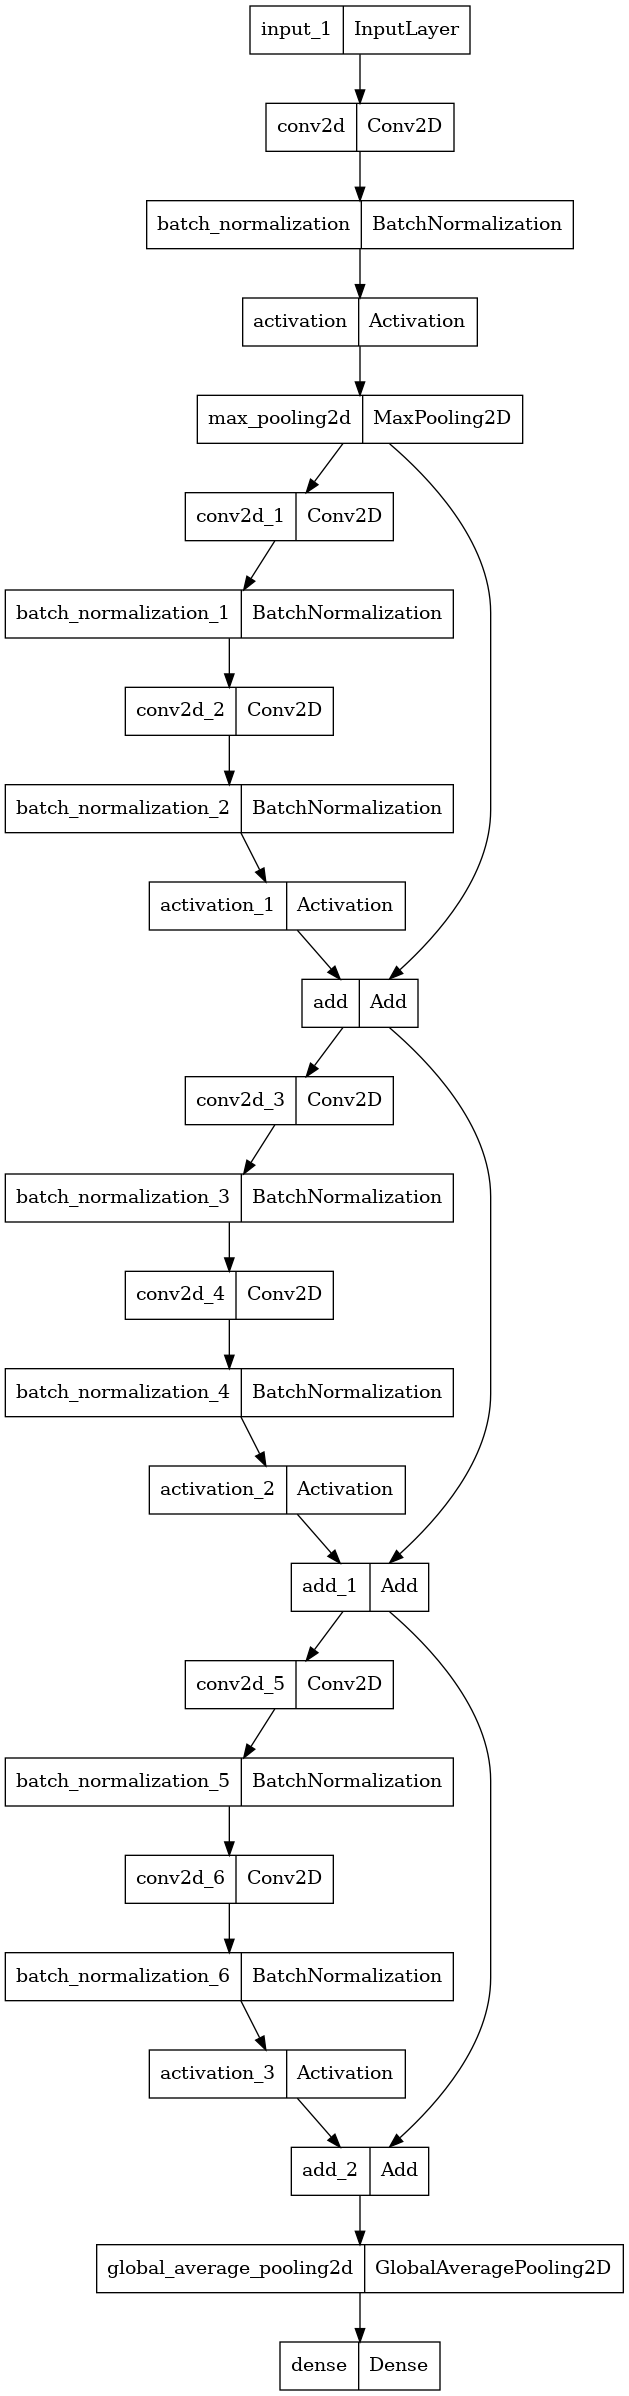

In [5]:
# Plot model

tf.keras.utils.plot_model(resnet_2)

In [6]:
# Model summary

resnet_2.summary()

Model: "Resnet_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           3200      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 28, 28, 64)           0         ['batch_normalization[0

## Implement Model subclasses

In [7]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
    
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.add([x, input_tensor])
        x = self.act(x)
        return x

In [8]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same', input_shape=(28, 28, 1))
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)
        self.id1c = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        x = self.id1a(x)
        x = self.id1b(x)
        x = self.id1c(x)

        x = self.global_pool(x)
        return self.classifier(x)

## Training the Model

In [9]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [10]:
train_images.shape

(60000, 28, 28, 1)

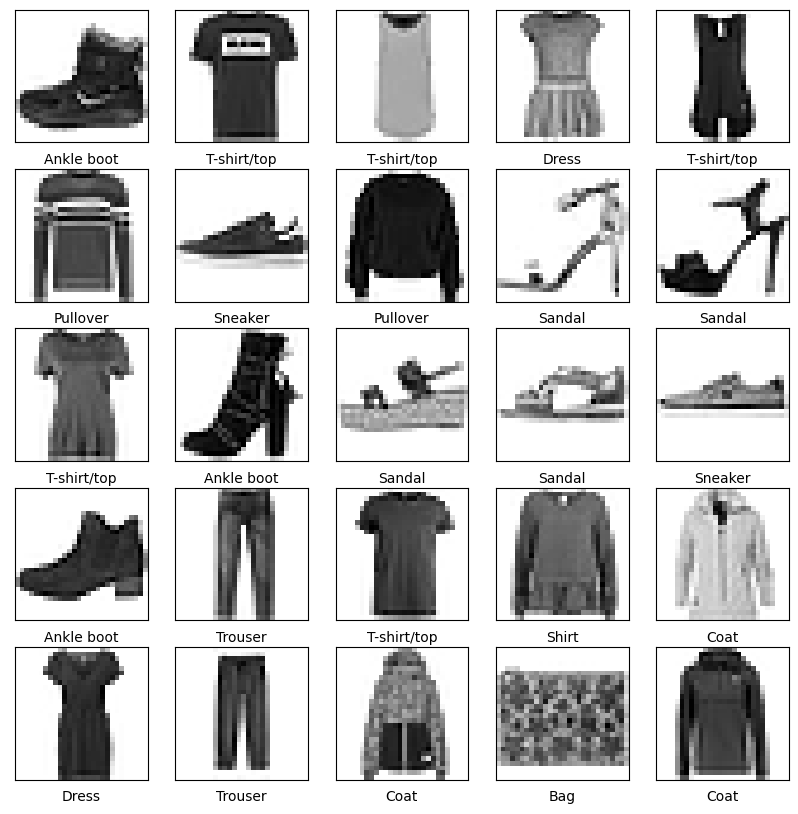

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [12]:
# Model instantiation and compilation

resnet = ResNet(10)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Train the model

history = resnet.fit(train_images,
                     train_labels,
                     batch_size=256,
                     epochs=20,
                     validation_data=(test_images, test_labels)
                    )

Epoch 1/20


I0000 00:00:1704475614.096340   28746 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 [==============================] - 7s 19ms/step - loss: 0.5567 - accuracy: 0.8029 - val_loss: 3.5424 - val_accuracy: 0.1653
Epoch 2/20
235/235 [==============================] - 4s 15ms/step - loss: 0.3307 - accuracy: 0.8797 - val_loss: 1.2189 - val_accuracy: 0.6971
Epoch 3/20
235/235 [==============================] - 4s 15ms/step - loss: 0.2849 - accuracy: 0.8963 - val_loss: 0.6809 - val_accuracy: 0.7815
Epoch 4/20
235/235 [==============================] - 3s 15ms/step - loss: 0.2549 - accuracy: 0.9068 - val_loss: 0.5535 - val_accuracy: 0.8063
Epoch 5/20
235/235 [==============================] - 3s 14ms/step - loss: 0.2409 - accuracy: 0.9119 - val_loss: 0.2970 - val_accuracy: 0.8932
Epoch 6/20
235/235 [==============================] - 4s 15ms/step - loss: 0.2216 - accuracy: 0.9192 - val_loss: 0.3578 - val_accuracy: 0.8758
Epoch 7/20
235/235 [==============================] - 3s 14ms/step - loss: 0.2110 - accuracy: 0.9230 - val_loss: 0.3233 - val_accuracy: 0.8888
Epoch 8/20

In [14]:
# Predictions

predictions = resnet.predict(test_images)

313/313 [==============================] - 1s 2ms/step


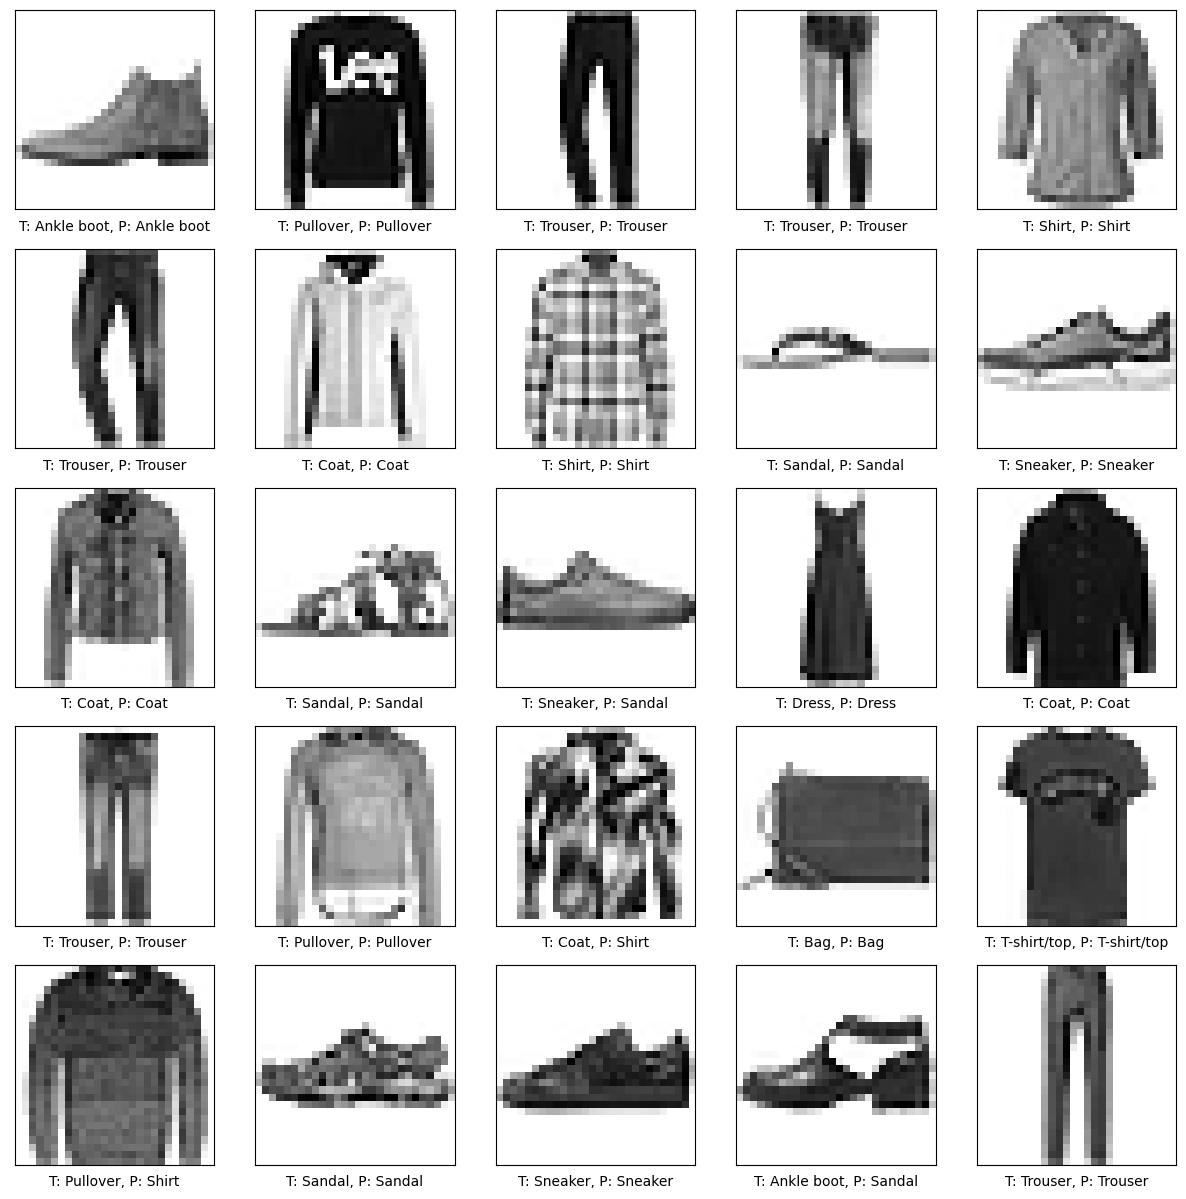

In [15]:
# Plot predictions

plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel("T: {0}, P: {1}".format(class_names[test_labels[i]],
                                                  class_names[np.argmax(predictions[i])])
              )
plt.show()

## Loss and accuracy

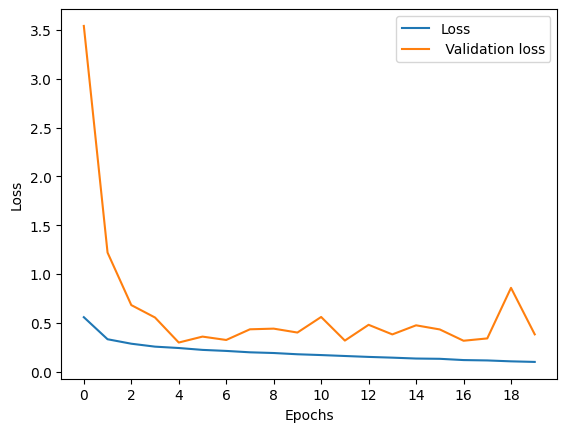

In [16]:
# Plot loss

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label=' Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(0, 20, step=2))
plt.show()

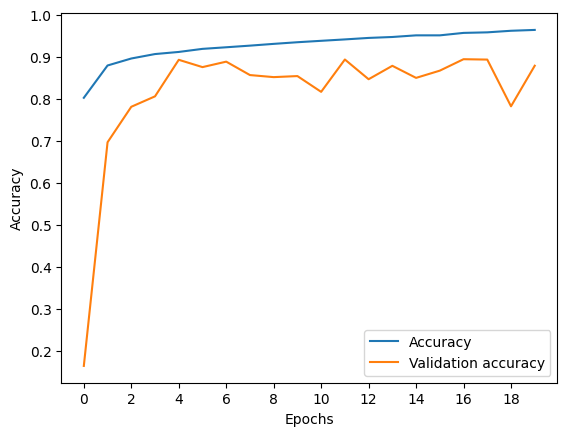

In [17]:
# Plot accuracy

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 20, step=2))
plt.legend()
plt.show()

## Visualizing filters

In [18]:
# Get weights

filters, biases = resnet.layers[0].get_weights()

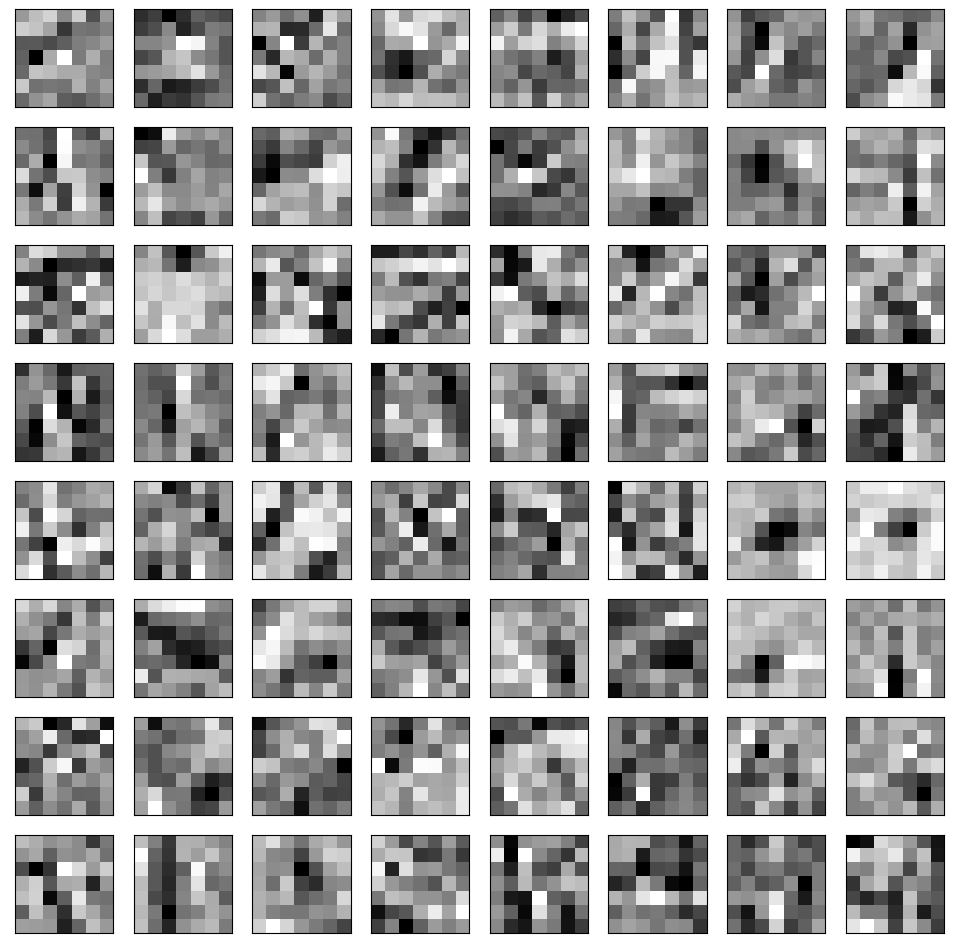

In [19]:
# Plot weights

square = 8
plt.figure(figsize=(12, 12))

ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.imshow(filters[:, :, 0, ix-1], cmap='gray')
        ix += 1

plt.show()

In [20]:
# Conv2d of filters applied to test_image[1]

fmaps = tf.nn.conv2d(test_images[1].reshape(1, 28, 28, 1),
                        filters[:, :, :, :],
                        strides=[1, 1, 1, 1],
                        padding='SAME'
                       )

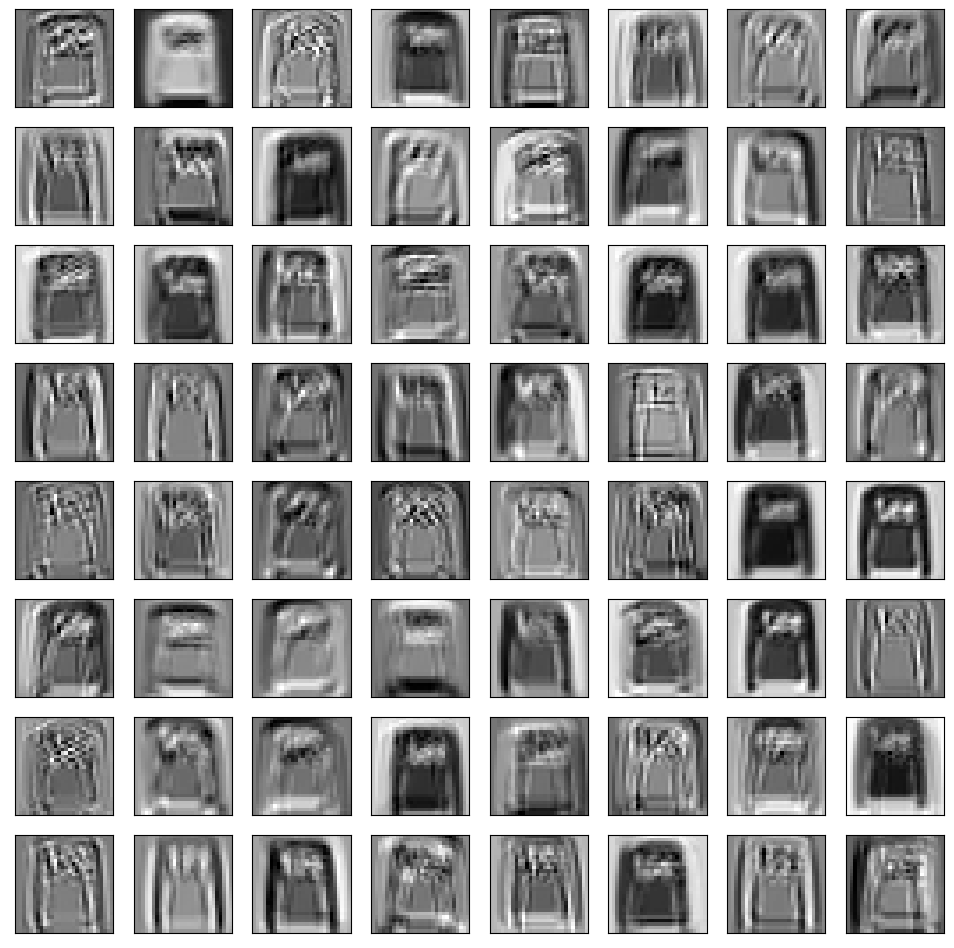

In [21]:
# Plot conv2d between filters and test_image[1]

square = 8
plt.figure(figsize=(12, 12))


ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.imshow(fmaps[0, :, :, ix-1], cmap='gray')
        ix += 1

plt.show()